# Notebook for IBM Data Science Capstone Project

In [1]:
import numpy as np
import pandas as pd
import json
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.pyplot as plt 
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium
from scipy.spatial import distance_matrix
import seaborn as sns
print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    numpy-1.18.1               |   py36h95a1406_0         5.2 MB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    sci

In [2]:
print('Hello Capstone Project Course!')

Hello Capstone Project Course!


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
neighborhoods = pd.DataFrame(columns=['Borough', 'Neighborhood', 'Latitude', 'Longitude'])
for data in newyork_data['features']:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
    neighborhood_coor = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_coor[1]
    neighborhood_lon = neighborhood_coor[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
pop_data = pd.read_csv('NewYorkPopulationData.csv')
pop_data['Total'] = pop_data['Total']/1000
pop_data['Males'] = pop_data['Males']/1000
pop_data['Females'] = pop_data['Females']/1000
pop_data.rename(columns={"Region":"Region", "Males":"Males (000s)", "Females":"Females (000s)", "Total":"Total (000s)"}, inplace=True)
pop_data.head(10)

,Region,Males (000s),Females (000s),Total (000s)
0,"Riverdale, Fieldston, Kingsbridge",51.598,61.481,113.079
1,"Wakefield, Williamsbridge, Woodlawn",65.216,78.387,143.604
2,"Co-op City, Pelham Bay, Schuylerville",55.037,65.204,120.241
3,"Pelham Parkway, Morris Park, Laconia",60.974,67.982,128.956
4,"Belmont, Crotona Park East, East Tremont",77.119,89.293,166.411
5,"Bedford Park, Fordham North, Norwood",63.169,68.921,132.090
6,"Morris Heights, Fordham South, Mount Hope",65.682,72.967,138.648
7,"Concourse, Highbridge, Mount Eden",68.152,75.978,144.129
8,"Castle Hill, Clason Point, Parkchester",88.007,100.193,188.201
9,"Hunts Point, Longwood, Melrose",81.666,79.759,161.425


In [6]:
neighborhoods['Region'] = 'N/A'
for index, row in pop_data.iterrows():
    for item in row['Region'].split(', '):
        neighborhoods['Region'][neighborhoods['Neighborhood'].str.lower() == item.lower()] = index
neighborhoods.head(10)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Borough,Neighborhood,Latitude,Longitude,Region
0,Bronx,Wakefield,40.894705,-73.847201,1
1,Bronx,Co-op City,40.874294,-73.829939,2
2,Bronx,Eastchester,40.887556,-73.827806,N/A
3,Bronx,Fieldston,40.895437,-73.905643,0
4,Bronx,Riverdale,40.890834,-73.912585,0
5,Bronx,Kingsbridge,40.881687,-73.902818,0
6,Manhattan,Marble Hill,40.876551,-73.910660,28
7,Bronx,Woodlawn,40.898273,-73.867315,1
8,Bronx,Norwood,40.877224,-73.879391,5
9,Bronx,Williamsbridge,40.881039,-73.857446,1


In [7]:
neighborhoods = neighborhoods[neighborhoods['Region'] != 'N/A']
neighborhoods.reset_index(drop=True, inplace=True)
print('There are a total of {} neighborhoods in consideration'.format(str(len(neighborhoods))))

There are a total of 122 neighborhoods in consideration


In [8]:
geolocator = Nominatim(user_agent="ny_explorer")
NY_location = geolocator.geocode('Brooklyn, NY')
map_newyork_2 = folium.Map(location=[NY_location.latitude, NY_location.longitude], zoom_start=10)
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork_2)  

map_newyork_2

In [9]:
radius = 5000
LIMIT = 50
CATEGORY_ID = '4bf58dd8d48988d16e941735'
CLIENT_ID = 'N2SZILEBYJCPYL22JG25TJGGJAMA21OM140H0CQE4PZNZUMY'
CLIENT_SECRET = 'KROU15EDDQQSZVPF1EO2DKD0AEAZ3A1VQEXOJLXO05PEPBDL'
VERSION = '20180605'


In [10]:
McD = pd.DataFrame(columns=['Name', 'ZipCode', 'Latitude', 'Longitude'])
for index, row in neighborhoods.iterrows():
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&query={}&categoryId={}'.format(
    CLIENT_ID, CLIENT_SECRET, row['Latitude'], row['Longitude'], VERSION, radius, LIMIT, 'McDonalds', CATEGORY_ID)
    results = requests.get(url).json()
    for data in results['response']['venues']:
        name = data['name']
        if 'postalCode' in data['location'].keys():
            code = data['location']['postalCode']
        else:
            code = np.nan
        lat = data['location']['lat']
        long = data['location']['lng']
        McD = McD.append({'Name': name,
                          'Latitude': lat,
                          'Longitude': long, 
                          'ZipCode': code}, ignore_index=True)
McD.drop_duplicates(inplace=True)
print(len(McD))
print(McD.head(10))

286
         Name ZipCode   Latitude  Longitude
0  McDonald's   10466  40.892779 -73.857473
1  McDonald's   10470  40.902645 -73.849485
2  McDonald's   10475  40.885636 -73.826840
3  McDonald's   10553  40.901017 -73.827341
4  McDonald's   10466  40.891376 -73.851632
5  McDonald's   10467  40.864027 -73.867063
6  McDonald's   10466  40.888810 -73.843010
7  McDonald's   10461  40.844517 -73.846573
8  McDonald's   10462  40.855519 -73.867346
9  McDonald's   10458  40.861685 -73.892471


In [11]:
McD['Name'].unique()

array(["McDonald's", 'Mcdonald 3rd Avenue', 'Mcdonaldz',
       "McDonald's Express", "McDowell's", 'McDonald’s Playplace',
       'Mc Takeout', "McDonald's of Perth Amboy"], dtype=object)

In [12]:
McD = McD[(McD['Name'] == "McDonald's") | (McD['Name'] == "McDonald's Express")]
McD.reset_index(drop=True, inplace=True)
print(len(McD))
print(McD.head(10))

279
         Name ZipCode   Latitude  Longitude
0  McDonald's   10466  40.892779 -73.857473
1  McDonald's   10470  40.902645 -73.849485
2  McDonald's   10475  40.885636 -73.826840
3  McDonald's   10553  40.901017 -73.827341
4  McDonald's   10466  40.891376 -73.851632
5  McDonald's   10467  40.864027 -73.867063
6  McDonald's   10466  40.888810 -73.843010
7  McDonald's   10461  40.844517 -73.846573
8  McDonald's   10462  40.855519 -73.867346
9  McDonald's   10458  40.861685 -73.892471


In [13]:
for index, row in McD.iterrows():
    label = str(index)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [row['Latitude'], row['Longitude']],
        radius=5,
        popup=label,
        color='red',
        parse_html=False).add_to(map_newyork_2)  

map_newyork_2

In [14]:
X = neighborhoods[['Latitude', 'Longitude']].values
y = McD[['Latitude', 'Longitude']].values
dist = distance_matrix(X, y)
np.shape(dist)

(122, 279)

In [15]:
McD['Nearest Neighborhood'] = dist.argmin(0)
McD.head(10)

,Name,ZipCode,Latitude,Longitude,Nearest Neighborhood
0,McDonald's,10466,40.892779,-73.857473,0
1,McDonald's,10470,40.902645,-73.849485,0
2,McDonald's,10475,40.885636,-73.826840,1
3,McDonald's,10553,40.901017,-73.827341,0
4,McDonald's,10466,40.891376,-73.851632,0
5,McDonald's,10467,40.864027,-73.867063,9
6,McDonald's,10466,40.888810,-73.843010,0
7,McDonald's,10461,40.844517,-73.846573,18
8,McDonald's,10462,40.855519,-73.867346,9
9,McDonald's,10458,40.861685,-73.892471,19


In [16]:
neighborhoods['Nearby McD Counts'] = 0
for index in range(len(neighborhoods)):
    neighborhoods['Nearby McD Counts'][index] = len(McD[McD['Nearest Neighborhood'] == index])

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
neighborhoods.groupby('Region')['Nearby McD Counts'].sum()

Region
0      3
1      9
2      5
3      5
4      8
5      4
6      4
7      5
8      3
9      9
10     4
11     2
12     4
13     5
14     2
15     2
16     3
17     3
18     7
19     4
20     2
21     5
22     2
23     2
24     3
25     3
26     3
27     2
28     7
29     8
30     8
31     4
32     3
33     5
34    22
35     6
36     3
37    12
38     4
39     5
40    16
41     4
42     9
43    10
44     1
45     3
46     2
47     5
48     5
49     2
50     3
51     5
52     4
53     4
54     6
Name: Nearby McD Counts, dtype: int64

In [18]:
pop_data['McD Counts'] = 0
pop_data['McD Counts'] = neighborhoods.groupby('Region')['Nearby McD Counts'].sum()
pop_data.head(5)

,Region,Males (000s),Females (000s),Total (000s),McD Counts
0,"Riverdale, Fieldston, Kingsbridge",51.598,61.481,113.079,3
1,"Wakefield, Williamsbridge, Woodlawn",65.216,78.387,143.604,9
2,"Co-op City, Pelham Bay, Schuylerville",55.037,65.204,120.241,5
3,"Pelham Parkway, Morris Park, Laconia",60.974,67.982,128.956,5
4,"Belmont, Crotona Park East, East Tremont",77.119,89.293,166.411,8


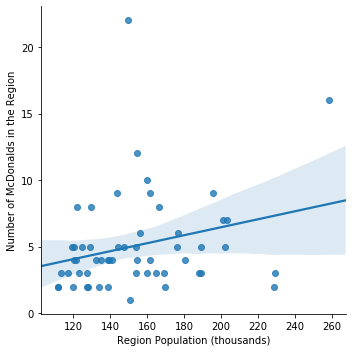

In [19]:
ax = sns.lmplot(x="Total (000s)", y="McD Counts", data=pop_data)
ax.set_axis_labels(x_var="Region Population (thousands)", y_var="Number of McDonalds in the Region")

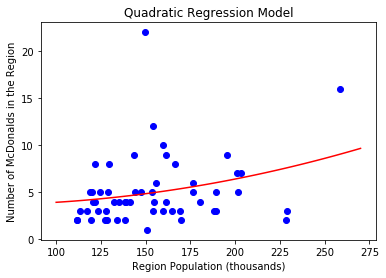

In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression 
# pop_data_dummy = pop_data_dummy[pop_data_dummy['McD Counts'] <= 10].reset_index(drop=True)
poly = PolynomialFeatures(degree = 2) 
X_poly = poly.fit_transform(pop_data[['Total (000s)']].values)
lin = LinearRegression()
lin.fit(X_poly, pop_data[['McD Counts']])

plt.scatter(pop_data['Total (000s)'], pop_data['McD Counts'], color = 'blue') 
plt.plot(np.linspace(100, 270), lin.predict(poly.fit_transform(np.linspace(100, 270).reshape(50, 1))), color = 'red') 
plt.title('Quadratic Regression Model') 
plt.xlabel('Region Population (thousands)') 
plt.ylabel('Number of McDonalds in the Region') 
  
plt.show() 


In [23]:
potential_regions = pop_data[(pop_data['Total (000s)'] >225)][pop_data['McD Counts'] < 5]
potential_regions

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Region,Males (000s),Females (000s),Total (000s),McD Counts
32,Upper East Side,102.121,127.056,229.177,3
49,"Jamaica, Hollis, St. Albans",105.917,122.616,228.533,2


In [24]:
potential_neighborhoods = neighborhoods[neighborhoods['Region'].isin(potential_regions.index)]
potential_neighborhoods.reset_index(drop=True, inplace=True)
potential_neighborhoods

,Borough,Neighborhood,Latitude,Longitude,Region,Nearby McD Counts
0,Manhattan,Upper East Side,40.775639,-73.960508,32,3
1,Queens,Hollis,40.711243,-73.759250,49,1
2,Queens,St. Albans,40.694445,-73.758676,49,1


In [25]:
for index, row in potential_neighborhoods.iterrows():
    label = 'Potential Openning Location #{}'.format(index)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [row['Latitude'], row['Longitude']],
        radius=25,
        popup=label,
        color='green',
        parse_html=False).add_to(map_newyork_2)

map_newyork_2.zoom_start = 11
map_newyork_2